# Réseau de neurones pour le calcul de flux pour l'advection en 2D

Importer les bibliothèques utiles 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sqlite3
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import datetime, os
from sklearn import metrics
from sklearn import preprocessing
from sklearn.utils import shuffle
from time import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm

from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import GridSearchCV

# Importer la grande base

In [2]:
con=sqlite3.connect('Table-2.db')
raw_data=pd.read_sql_query("SELECT * FROM A",con)
data = raw_data.copy()
print(data.tail())
print(type(data))

                   P1            P2            P3            P4            P5  \
3991999  1.044813e-24  1.365423e-24  1.783170e-24  1.044813e-24  1.580897e-24   
3992000  1.073063e-24  9.264329e-25  7.989262e-25  1.401159e-24  1.210625e-24   
3992001  1.828304e-24  1.401159e-24  1.073063e-24  1.580897e-24  1.210625e-24   
3992002  1.365423e-24  1.580897e-24  1.828304e-24  1.044813e-24  1.210625e-24   
3992003  7.989262e-25  1.044813e-24  1.365423e-24  7.989262e-25  1.210625e-24   

                   P6            P7            P8            P9            F1  \
3991999  2.384010e-24  1.401159e-24  1.401159e-24  2.384010e-24  1.127537e-27   
3992000  1.044813e-24  1.828304e-24  1.580897e-24  1.365423e-24  5.199348e-28   
3992001  7.989262e-25  1.365423e-24  1.044813e-24  7.989262e-25  1.000165e-27   
3992002  1.073063e-24  7.989262e-25  7.989262e-25  1.073063e-24  6.791624e-28   
3992003  1.828304e-24  1.073063e-24  1.073063e-24  1.828304e-24  8.637148e-28   

         ...            F3

# Introduction de la stabilité

<class 'pandas.core.series.Series'>


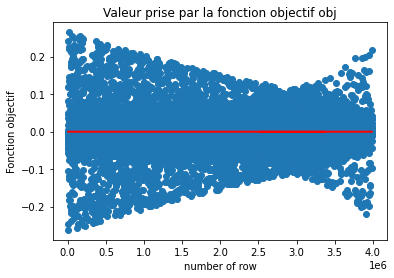

In [3]:
#On peut tester une petite proportion de data (plus rapide)
small_data=data.sample(frac=0.0025,random_state=0) #extraire 
small_data=shuffle(small_data) #shuffle

#test rapide i=1, gros test i=2
i=1

if i==1:
    #Attention, on devra faire varier dt et dx (=dy)
    dx=1/1001 #?
    dy=1/1001 #?
    dt=0.01 #?

    #Calcul fonction objectif
    w = small_data['P5']
    print(type(w))
    obj = ((small_data['F1']-small_data['F4'])/(dx*w))+((small_data['F3']-small_data['F2'])/(dy*w))
    
    #A retenir: j'utilise le fait que la serie 'obj' suit le meme ordre d'indentation que small_data, est-ce vrai?
    
    absi = small_data.index
    plt.scatter(absi,obj)
    nul = [0 for i in range((small_data.shape)[0])]
    plt.plot(absi,nul,'r')
    plt.title('Valeur prise par la fonction objectif obj')
    plt.xlabel('number of row')
    plt.ylabel('Fonction objectif')
    
elif i==2:
    #Attention, on devra faire varier dt et dx (=dy)
    dx=1/1001 #?
    dy=1/1001 #?
    dt=0.01 #?

    #Calcul fonction objectif
    w = data['P5']
    print(type(w))
    obj = ((data['F1']-data['F4'])/(dx*w))+((data['F3']-data['F2'])/(dy*w))
    
    #A retenir: j'utilise le fait que la serie 'obj' suit le meme ordre d'indentation que small_data, est-ce vrai?
    
    absi = data.index
    plt.scatter(absi,obj)
    nul = [0 for i in range((data.shape)[0])]
    plt.plot(absi,nul,'r')
    plt.title('Valeur prise par la fonction objectif obj')
    plt.xlabel('number of row')
    plt.ylabel('Fonction objectif')


but : moyenne = 0 et Ecart type = 1 >> recours a la fonction : preprocessing.StandardScaler()



# Shuffle (améliore la généralisation)

In [4]:
data = data.sample(frac = 1)
data


,P1,P2,P3,P4,P5,P6,P7,P8,P9,F1,...,F3,F4,A1,B1,A2,B2,A3,B3,A4,B4
2248894,2.497426e-08,2.412257e-08,2.329750e-08,2.286268e-08,2.208230e-08,1.951644e-08,2.092372e-08,2.092372e-08,1.951644e-08,1.752041e-11,...,1.386526e-11,1.603626e-11,-0.532827,-0.846224,-0.707330,-0.706883,-0.706624,-0.707589,-0.533672,-0.845691
2564373,1.475873e-05,1.374050e-05,1.278884e-05,1.514123e-05,1.409702e-05,1.346065e-05,1.553224e-05,1.446148e-05,1.346065e-05,8.420190e-09,...,9.782831e-09,8.638261e-09,0.742658,-0.669671,0.801582,-0.597884,0.800985,-0.598685,0.741988,-0.670413
1141261,1.008532e-07,9.472649e-08,8.895420e-08,1.061096e-07,9.967156e-08,9.848972e-08,1.116284e-07,1.048639e-07,9.848972e-08,4.955220e-11,...,8.311077e-11,5.213607e-11,0.825392,-0.564560,0.959601,-0.281364,0.959320,-0.282322,0.824828,-0.565384
2967416,1.006141e-01,1.018747e-01,1.031450e-01,1.037345e-01,1.050284e-01,1.063320e-01,1.069257e-01,1.082534e-01,1.095910e-01,6.846926e-05,...,5.348521e-05,7.058042e-05,0.676321,0.736607,0.561257,0.827641,0.562084,0.827080,0.675585,0.737282
1681905,3.079158e-16,2.719984e-16,2.402068e-16,3.255089e-16,2.875511e-16,2.684480e-16,3.440613e-16,3.039526e-16,2.684480e-16,1.977550e-19,...,2.211600e-19,2.090481e-19,0.625047,-0.780587,0.913056,-0.407833,0.912648,-0.408745,0.624267,-0.781211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922494,2.134899e-19,1.974123e-19,1.825201e-19,1.883738e-19,1.741730e-19,1.420181e-19,1.661716e-19,1.661716e-19,1.420181e-19,1.616859e-22,...,1.142531e-22,1.426342e-22,-0.228240,-0.973605,-0.753682,-0.657239,-0.753025,-0.657992,-0.229213,-0.973376
1372184,6.949699e-03,7.158998e-03,7.373900e-03,7.123843e-03,7.337908e-03,7.557687e-03,7.301487e-03,7.520399e-03,7.745139e-03,6.125756e-06,...,2.549152e-06,6.278492e-06,0.337402,0.941361,0.379366,0.925247,0.380290,0.924867,0.336462,0.941697
3762400,9.412681e-01,9.424036e-01,9.435218e-01,9.465907e-01,9.476849e-01,9.487617e-01,9.516737e-01,9.527252e-01,9.537593e-01,5.000876e-04,...,4.398362e-04,5.028199e-04,0.808476,0.588529,0.514958,0.857215,0.515814,0.856700,0.807888,0.589336
2600396,5.301903e-06,5.437125e-06,5.575271e-06,5.720176e-06,5.865940e-06,6.014854e-06,6.169616e-06,6.326696e-06,6.487168e-06,4.034917e-09,...,3.653705e-09,4.352500e-09,0.605862,0.795570,0.680725,0.732539,0.681456,0.731859,0.605067,0.796174


# Scaler la grande base

In [5]:
#On normalise avec scaler classique sur tout

x=data.values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
data_scaled = pd.DataFrame(x_scaled)
col = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','F1','F2','F3','F4','A1','B1','A2','B2','A3','B3','A4','B4']
data_scaled.columns = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','F1','F2','F3','F4','A1','B1','A2','B2','A3','B3','A4','B4']

print('moyenne:',scaler.mean_)
print('std',scaler.var_)


###Introduction inverse transform pour les flux
output_unscaled = data[['F1','F2','F3','F4']]
output_unscaled_values = output_unscaled.values
output_scaler = preprocessing.StandardScaler()
output_scaled_values = output_scaler.fit_transform(output_unscaled_values)

###Introduction inverse transform pour les valeurs d'entree du réseau
input_unscaled = data[['P1','P2','P3','P4','P5','P6','P7','P8','P9','A1','B1','A2','B2','A3','B3','A4','B4']]
input_unscaled_values = input_unscaled.values
input_scaler = preprocessing.StandardScaler()
input_scaler.fit(input_unscaled_values)

moyenne: [ 1.60349265e-01  1.60349330e-01  1.60349265e-01  1.60385081e-01
  1.60349394e-01  1.60286411e-01  1.60349265e-01  1.60322227e-01
  1.60349265e-01  7.77446432e-05  7.77446432e-05  7.77446432e-05
  7.77446432e-05  3.24974506e-04  9.55264427e-05 -9.55264427e-05
  3.24974506e-04  9.55264427e-05 -3.24974506e-04 -3.24974506e-04
 -9.55264427e-05]
std [8.78614806e-02 8.78615044e-02 8.78614806e-02 8.78751162e-02
 8.78615281e-02 8.78371894e-02 8.78614806e-02 8.78508294e-02
 8.78614806e-02 2.75861539e-08 2.75861539e-08 2.75861539e-08
 2.75861539e-08 4.99999894e-01 4.99999991e-01 4.99999991e-01
 4.99999894e-01 4.99999991e-01 4.99999894e-01 4.99999894e-01
 4.99999991e-01]


StandardScaler()

## Diviser la base de donnée 0.7 > entrainement ET 0.3 > test

In [6]:
print('The shape of the initial data before spliting it'+str(data_scaled.shape))


data_training=data_scaled.sample(frac=0.7,random_state=0) 
data_test=data_scaled.drop(data_training.index)

print('The shape of the initial data for training'+str(data_training.shape))
print('The shape of the initial data for testing'+str(data_test.shape))


data_training_labels = pd.DataFrame(columns =['F1','F2','F3','F4'])
data_test_labels = pd.DataFrame(columns =['F1','F2','F3','F4'])

data_training_labels['F1']=data_training['F1']
data_training_labels['F2']=data_training['F2']
data_training_labels['F3']=data_training['F3']
data_training_labels['F4']=data_training['F4']


data_test_labels['F1']=data_test['F1']
data_test_labels['F2']=data_test['F2']
data_test_labels['F3']=data_test['F3']
data_test_labels['F4']=data_test['F4']


data_training.pop('F1')
data_training.pop('F2')
data_training.pop('F3')
data_training.pop('F4')

data_test.pop('F1')
data_test.pop('F2')
data_test.pop('F3')
data_test.pop('F4')

data_training_features=data_training
data_test_features=data_test

print('The shape of the features dataframe for training'+str(data_training_features.shape))
print('The shape of the features dataframe for testing'+str(data_test_features.shape))
print('The shape of the labels dataframe for training'+str(data_training_labels.shape))
print('The shape of the labels dataframe for testing'+str(data_test_labels.shape))


The shape of the initial data before spliting it(3992004, 21)
The shape of the initial data for training(2794403, 21)
The shape of the initial data for testing(1197601, 21)
The shape of the features dataframe for training(2794403, 17)
The shape of the features dataframe for testing(1197601, 17)
The shape of the labels dataframe for training(2794403, 4)
The shape of the labels dataframe for testing(1197601, 4)


## Créer le modèle de réseau de neurones ( fonction d'activation = LeakyRelu ) 

Définir shape = nombre de 'features' d'entrée

In [7]:
shape = len(data.columns)-4

On crée le réseau de neuronnes avec une implémentation du Dropout, BUT : Regularisation et diminuer l'effet du overfitting (Dropout > randomly reducing the number of interconnecting neurons within a neural network), on choisit le dropout_rate=0.2, et on l'applique sur toute les Hidden layers.




Define Loss functionaa

function(y_true (type:tensor), y_pred (type:tensor))
returns: loss (type: scaler)


In [8]:
def f_loss(y_true, y_pred):
    
    dx_tensor=tf.constant(1/1001)
    dy_tensor=tf.constant(1/1001)
    e = 0.000001
    n = 2
    
    wobj_list = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in range(0,tf.shape(y_pred)[0]):        
        wobj_list = wobj_list.write(i,tf.add(tf.divide(tf.subtract(y_pred[i][0],y_pred[i][3]),dx_tensor),tf.divide(tf.subtract(y_pred[i][2],y_pred[i][1]),dy_tensor)))
        
    wobj = wobj_list.stack()
        
    mse = tf.reduce_mean(tf.square(tf.subtract(y_true,y_pred)))
    rest = e*pow(tf.maximum(0.0,-wobj),n)
    
    loss = mse + tf.reduce_mean(rest)
    
    return loss    

Nombre de degré de liberté du réseau : 6 051 , du meme ordre de la taille de la base de données => Overfitting/Underfitting évité

Optimiser le réseau, on choisit l'algorithm Adam et 20 000 epoches ( on peut changer d'algorithm d'optimisation apres ( gradient descent par exemple ), ca dependra de la performance ) 
On a pas encore Etudié le batch_size, on met une valeur arbitraire de 128

In [25]:
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(17,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(70,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(40,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(70,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(4,use_bias=True,activation='elu'))

    return model

model = build_model()
model.summary()

def train_model():
  
    
  optimizer = tf.optimizers.Adam() #Algorithm d'optimisation

  model.compile(loss=f_loss,
                optimizer='adam',
                metrics=['mse'])

  early_stop = keras.callbacks.EarlyStopping(monitor='val_mse',min_delta=1e-17, patience=10)
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1,profile_batch=0)


  model.fit(data_training_features, 
            data_training_labels, 
            epochs=1300,
            batch_size=120,
            validation_split = 0.5, 
            verbose=0, 
            callbacks=[early_stop,tensorboard_callback])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 17)                306       
_________________________________________________________________
dropout_16 (Dropout)         (None, 17)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 70)                1260      
_________________________________________________________________
dropout_17 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 40)                2840      
_________________________________________________________________
dropout_18 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 70)               

La méthode callbacks.TensorBoard() a été ajouté pour conserver la performence du Réseau de neurones a chaque itération (epochs) et visualiser les courbes a la fin

# Save the model in .h5 format 

In [26]:
train_model()
model.save("Advection2D_contrainteLoss-1.h5")

# Résultats

In [27]:
Y_pred_scaled=model.predict(data_test_features) #output du réseau, qu'on veut comparer a Y_test
Y_test_scaled=data_test_labels

Y_pred_df=pd.DataFrame(Y_pred_scaled,columns=['F1','F2','F3','F4'])


In [28]:
Y_pred_unscaled = output_scaler.inverse_transform(Y_pred_scaled)
Y_test_unscaled = output_scaler.inverse_transform(Y_test_scaled)

Y_pred_unscaled_df = pd.DataFrame(Y_pred_unscaled,columns=['F1','F2','F3','F4'])
Y_test_unscaled_df = pd.DataFrame(Y_test_unscaled,columns=['F1','F2','F3','F4'])


Affichage de la fontion wobj dénormalisés

moyenne: 9.75040759315737e-05
ecart-type: 0.00011589449415038753
moyenne du scaler[7.77446432e-05 7.77446432e-05 7.77446432e-05 7.77446432e-05]
variance du scaler[2.75861539e-08 2.75861539e-08 2.75861539e-08 2.75861539e-08]
nb de wobj_unscaled effectué positif: 1197601
nb de wobj_unscaled effectué négatif: 0


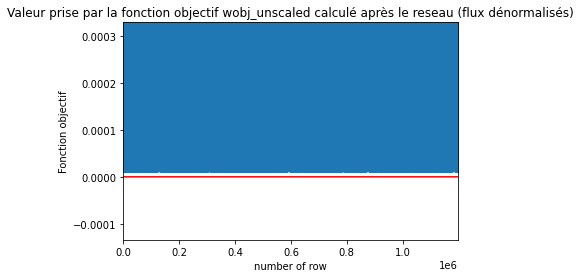

In [29]:
#On va étudier avec wobj en dénormalisé
dx=1/1001 #? Attention; ils ne sont pas normalisés ceux-là!
dy=1/1001 #?
dt=0.01 #?
wobj_unscaled = ((Y_pred_unscaled_df['F1']-Y_pred_unscaled_df['F4'])/(dx))+((Y_pred_unscaled_df['F3']-Y_pred_unscaled_df['F2'])/(dy))

absi = wobj_unscaled.index
plt.scatter(absi,wobj_unscaled)
print('moyenne:',wobj_unscaled.mean())
print('ecart-type:',wobj_unscaled.std())
nul = [0 for i in range((wobj_unscaled.shape)[0])]
plt.plot(absi,nul,'r')


x_min = absi[0]
x_max = absi.shape[0]
y_max = wobj_unscaled.mean() + 2*wobj_unscaled.std()
y_min = wobj_unscaled.mean() - 2*wobj_unscaled.std()
print('moyenne du scaler'+str(output_scaler.mean_))
print('variance du scaler'+str(output_scaler.var_))

plt.title('Valeur prise par la fonction objectif wobj_unscaled calculé après le reseau (flux dénormalisés)')
plt.xlabel('number of row')
plt.ylabel('Fonction objectif')
plt.axis([x_min, x_max, y_min, y_max])


### Ici tout est dénormalisé
wobj_unscaled = wobj_unscaled.to_frame()
wobj_unscaled.columns = ['wobj_unscaled']

au_dessus_realise = wobj_unscaled.loc[wobj_unscaled['wobj_unscaled']>=0]
nb_au_dessus_realise = au_dessus_realise.shape[0]
print('nb de wobj_unscaled effectué positif: '+str(nb_au_dessus_realise))
en_dessous_realise = wobj_unscaled.loc[wobj_unscaled['wobj_unscaled']<0]
nb_en_dessous_realise = en_dessous_realise.shape[0]
print('nb de wobj_unscaled effectué négatif: '+str(nb_en_dessous_realise))


In [32]:
def visualize1(): #we feed it the test data
    plt.scatter(data_test_labels['F1'],Y_pred_df['F1'], color = 'red',marker=".")
    plt.scatter(data_test_labels['F1'],data_test_labels['F1'], color = 'black',marker=".") #just for the y=x black line, the result (red points) should be close to the line
    
    plt.title('Neural Network prediction de F1')
    plt.xlabel('exact')
    plt.ylabel('prediction')
    
    R2=metrics.r2_score(data_test_labels, Y_pred_df)
    
  
    print('Model Performance')
   
    print('R2: {:0.4f}.'.format(R2))
    
    plt.show()   


In [67]:
def visualize2(): #we feed it the test data
    plt.scatter(data_test_labels['F2'],Y_pred_df['F2'], color = 'red',marker=".")
    plt.scatter(data_test_labels['F2'],data_test_labels['F2'], color = 'black',marker=".") #just for the y=x black line, the result (red points) should be close to the line
    
    
    plt.title('Neural Network prediction de F2')
    plt.xlabel('exact')
    plt.ylabel('prediction')
    
    R2=metrics.r2_score(data_test_labels, Y_pred_df)
    
   
    
    print('Model Performance')
 
    print('R2: {:0.4f}.'.format(R2))
    
    plt.show()

In [68]:
def visualize3(): #we feed it the test data
    plt.scatter(data_test_labels['F3'],Y_pred_df['F3'], color = 'red',marker=".")
    plt.scatter(data_test_labels['F3'],data_test_labels['F3'], color = 'black',marker=".") #just for the y=x black line, the result (red points) should be close to the line
    
    
    plt.title('Neural Network prediction de F3')
    plt.xlabel('exact')
    plt.ylabel('prediction')
    
    R2=metrics.r2_score(data_test_labels, Y_pred_df)
    
    Correl=np.corrcoef(data_test_labels, Y_pred_df)[0, 1]
    
    print('Model Performance')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))
    
    plt.show()

In [69]:
def visualize4(): #we feed it the test data
    plt.scatter(data_test_labels['F4'],Y_pred_df['F4'], color = 'red',marker=".")
    plt.scatter(data_test_labels['F4'],data_test_labels['F4'], color = 'black',marker=".") #just for the y=x black line, the result (red points) should be close to the line
    
    
    plt.title('Neural Network prediction de F4')
    plt.xlabel('exact')
    plt.ylabel('prediction')
    
    R2=metrics.r2_score(data_test_labels, Y_pred_df)
    
    Correl=np.corrcoef(data_test_labels, Y_pred_df)[0, 1]
    
    print('Model Performance')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))
    
    plt.show()

Model Performance
R2: 0.9814.


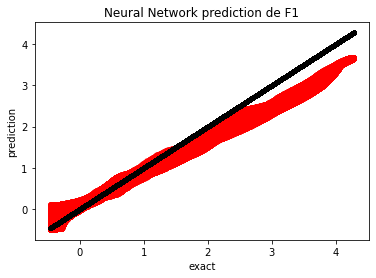

In [33]:
visualize1()

Model Performance
Correlation: 1.0000.
R2: 0.9537.


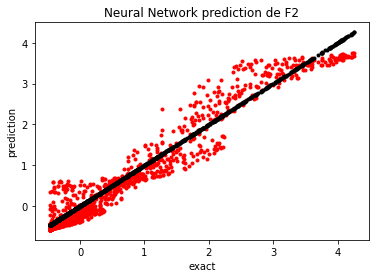

In [71]:
visualize2()

Model Performance
Correlation: 1.0000.
R2: 0.9537.


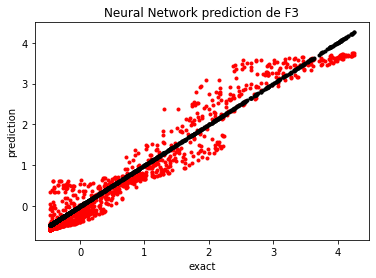

In [72]:
visualize3()

Model Performance
Correlation: 1.0000.
R2: 0.9537.


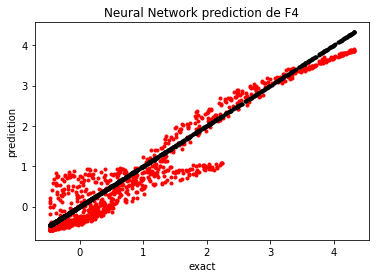

In [73]:
visualize4()

# Visualisation de la Loss-fonction

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit